In [1]:
import pandas as pd
import numpy as np
!pip install lightgbm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
import gc # Garbage Collector
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
##set---->>>
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print(f'Mem. usage decreased to {end_mem:5.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

def calculate_hit_rate_at_3(df_preds_with_true_and_rank):
    """
    Calculates HitRate@3.
    df_preds_with_true_and_rank must have:
        - 'ranker_id'
        - 'selected' (true binary target, 1 for chosen)
        - 'predicted_rank' (rank assigned by the model, 1 is best)
    """
    hits = 0
    valid_queries_count = 0
    
    for ranker_id, group in df_preds_with_true_and_rank.groupby('ranker_id'):
        if len(group) <= 10:
            continue  # Skip groups with 10 or fewer options as per competition rules
        
        valid_queries_count += 1
        
        true_selected_item = group[group['selected'] == 1]
        
        if not true_selected_item.empty:
            # Get the rank of the true selected item
            rank_of_true_item = true_selected_item.iloc[0]['predicted_rank']
            if rank_of_true_item <= 3:
                hits += 1
        # else:
            # This shouldn't happen in validation if data is prepared correctly from train
            # print(f"Warning: No selected item found for ranker_id {ranker_id} in HitRate calculation.")
            
    if valid_queries_count == 0:
        return 0.0
    return hits / valid_queries_count

In [3]:
# block 3: Load the Data
import pandas as pd
import numpy as np
import gc

initial_core_columns = [
    'Id', 'ranker_id', 'selected', 'profileId', 'companyID',
    'requestDate', 'totalPrice', 'taxes',
    'legs0_departureAt', 'legs0_arrivalAt', 'legs0_duration',
    'legs1_departureAt', 'legs1_arrivalAt', 'legs1_duration',
    'legs0_segments0_departureFrom_airport_iata', 'legs0_segments0_arrivalTo_airport_iata',
    'legs0_segments0_marketingCarrier_code', 'legs0_segments0_cabinClass',
    'legs0_segments0_baggageAllowance_quantity',
    'searchRoute',
    'pricingInfo_isAccessTP', 'pricingInfo_passengerCount',
    'sex', 'nationality', 'isVip',
    'miniRules0_monetaryAmount', 'miniRules0_percentage', 
    'miniRules1_monetaryAmount', 'miniRules1_percentage'
]
initial_core_columns_test = [col for col in initial_core_columns if col != 'selected']

print("Loading a subset of columns for train_df...")
train_df = pd.read_parquet('/kaggle/input/aeroclub-recsys-2025/train.parquet', columns=initial_core_columns)
print("Loading a subset of columns for test_df...")
test_df = pd.read_parquet('/kaggle/input/aeroclub-recsys-2025/test.parquet', columns=initial_core_columns_test)
sample_submission_df = pd.read_parquet('/kaggle/input/aeroclub-recsys-2025/sample_submission.parquet')

print("\nTrain DataFrame (after loading subset - BEFORE reduce_mem_usage and any FE):")
train_df.info(memory_usage='deep')
print(f"\nShape: {train_df.shape}")
print("\nTest DataFrame (after loading subset - BEFORE reduce_mem_usage and any FE):")
test_df.info(memory_usage='deep')
print(f"\nShape: {test_df.shape}")

if 'Id' in test_df.columns and 'ranker_id' in test_df.columns:
    test_ids_df = test_df[['Id', 'ranker_id']].copy()
else:
    print("Warning: 'Id' or 'ranker_id' not found in loaded test_df columns. Submission might fail.")
    try:
        temp_ids = pd.read_parquet('/kaggle/input/aeroclub-recsys-2025/test.parquet', columns=['Id', 'ranker_id'])
        test_ids_df = temp_ids.copy()
        del temp_ids
    except Exception as e:
        print(f"Fallback to load test Ids failed: {e}")
        test_ids_df = pd.DataFrame()
gc.collect()

Loading a subset of columns for train_df...
Loading a subset of columns for test_df...

Train DataFrame (after loading subset - BEFORE reduce_mem_usage and any FE):
<class 'pandas.core.frame.DataFrame'>
Index: 18145372 entries, 0 to 18146431
Data columns (total 29 columns):
 #   Column                                      Dtype         
---  ------                                      -----         
 0   Id                                          int64         
 1   ranker_id                                   object        
 2   selected                                    int64         
 3   profileId                                   int64         
 4   companyID                                   int64         
 5   requestDate                                 datetime64[ns]
 6   totalPrice                                  float64       
 7   taxes                                       float64       
 8   legs0_departureAt                           object        
 9   legs0_arrivalAt 

13

In [4]:
# Block 4: Feature Engineering there in it 

def create_initial_datetime_features(df):
    loaded_cols = df.columns
    potential_dt_cols = ['requestDate', 'legs0_departureAt', 'legs0_arrivalAt', 'legs1_departureAt', 'legs1_arrivalAt']
    for col in potential_dt_cols:
        if col in loaded_cols:
            if not pd.api.types.is_datetime64_any_dtype(df[col]):
                current_dtype = df[col].dtype
                print(f"Converting column {col} (current dtype: {current_dtype}) to datetime.")
                df[col] = pd.to_datetime(df[col].astype(str), errors='coerce')
    return df

def create_remaining_features(df, is_train=True):
    # --- Date/Time Component Extraction ---
    potential_dt_cols_for_components = ['legs0_departureAt', 'legs0_arrivalAt', 'legs1_departureAt', 'legs1_arrivalAt']
    for col in potential_dt_cols_for_components:
        if col in df.columns and pd.api.types.is_datetime64_any_dtype(df[col]):
             df[col + '_hour'] = df[col].dt.hour.astype(np.int8, errors='ignore')
             df[col + '_dow'] = df[col].dt.dayofweek.astype(np.int8, errors='ignore')

    # --- Booking Lead Time ---
    if 'legs0_departureAt' in df.columns and 'requestDate' in df.columns and \
       pd.api.types.is_datetime64_any_dtype(df['legs0_departureAt']) and \
       pd.api.types.is_datetime64_any_dtype(df['requestDate']):
        df['booking_lead_days'] = (df['legs0_departureAt'] - df['requestDate']).dt.total_seconds() / (24 * 60 * 60)
        df['booking_lead_days'] = df['booking_lead_days'].fillna(-1).astype(np.float32)
    else:
        missing_cols = [c for c in ['legs0_departureAt', 'requestDate'] if c not in df.columns]
        if missing_cols: print(f"Warning: Columns {missing_cols} not found for booking_lead_days.")
        else: print(f"Warning: Dtype issue for booking_lead_days. legs0_dep: {df.get('legs0_departureAt', pd.Series(dtype='object')).dtype}, reqDate: {df.get('requestDate', pd.Series(dtype='object')).dtype}")
        df['booking_lead_days'] = -1.0

    # --- Route Features ---
    if 'searchRoute' in df.columns: df['is_round_trip'] = df['searchRoute'].astype(str).str.contains('/').astype(np.int8)
    else: df['is_round_trip'] = -1 
    
    if 'legs1_departureAt' in df.columns and pd.api.types.is_datetime64_any_dtype(df['legs1_departureAt']):
        df['num_legs'] = 1 + df['legs1_departureAt'].notna().astype(np.int8)
    elif 'legs1_departureAt' in df.columns :
         df['num_legs'] = 1 + pd.to_datetime(df['legs1_departureAt'].astype(str),errors='coerce').notna().astype(np.int8)
    else: df['num_legs'] = 1

    # --- Segment Count ---
    df['num_segments_leg0'] = 0; df['num_segments_leg1'] = 0
    if 'legs0_segments0_departureFrom_airport_iata' in df.columns: df['num_segments_leg0'] += df['legs0_segments0_departureFrom_airport_iata'].notna().astype(np.int8)
    if 'legs1_segments0_departureFrom_airport_iata' in df.columns: df['num_segments_leg1'] += df['legs1_segments0_departureFrom_airport_iata'].notna().astype(np.int8)
   
    df['total_segments'] = (df['num_segments_leg0'] + df['num_segments_leg1']).astype(np.int8)
    
    # --- Flight Duration ---
    for dur_col in ['legs0_duration', 'legs1_duration']:
        if dur_col in df.columns:
            if not pd.api.types.is_numeric_dtype(df[dur_col]):
                df[dur_col] = pd.to_numeric(df[dur_col].astype(str), errors='coerce').fillna(0)
            else: df[dur_col] = df[dur_col].fillna(0)
        else: df[dur_col] = 0 
    df['total_flight_duration'] = (df['legs0_duration'] + df['legs1_duration']).astype(np.float32)

    # --- Price Features ---
    if 'totalPrice' in df.columns and 'taxes' in df.columns:
        df['price_per_duration'] = (df['totalPrice'] / (df['total_flight_duration'] + 1e-6)).fillna(0).astype(np.float32)
        df['tax_percentage'] = (df['taxes'] / (df['totalPrice'] + 1e-6)).fillna(0) * 100
        df['tax_percentage'] = df['tax_percentage'].astype(np.float32)
    else: df['price_per_duration'] = 0.0; df['tax_percentage'] = 0.0

    # --- Policy/Convenience ---
    if 'pricingInfo_isAccessTP' in df.columns: df['is_compliant'] = df['pricingInfo_isAccessTP'].fillna(0).astype(np.int8)
    else: df['is_compliant'] = -1
    
    if 'legs0_segments0_baggageAllowance_quantity' in df.columns: df['baggage_leg0_included'] = (df['legs0_segments0_baggageAllowance_quantity'].fillna(0) > 0).astype(np.int8)
    else: df['baggage_leg0_included'] = -1
        
    if 'legs1_segments0_baggageAllowance_quantity' in df.columns: # Giả sử chỉ có segment 0 được tải cho leg 1
        df['baggage_leg1_included'] = (df['legs1_segments0_baggageAllowance_quantity'].fillna(0) > 0).astype(np.int8)
        if 'baggage_leg0_included' in df.columns and df['baggage_leg0_included'].iloc[0] != -1:
             df['baggage_both_legs_included'] = (df['baggage_leg0_included'] & df['baggage_leg1_included']).astype(np.int8)
        else: df['baggage_both_legs_included'] = -1
    else: 
        df['baggage_leg1_included'] = 0 
        if 'baggage_leg0_included' in df.columns and df['baggage_leg0_included'].iloc[0] != -1:
            df['baggage_both_legs_included'] = df['baggage_leg0_included'].astype(np.int8)
        else: df['baggage_both_legs_included'] = -1
    
    # --- Cancellation/Exchange ---
    df['free_cancel'] = -1; df['free_exchange'] = -1
    if 'miniRules0_monetaryAmount' in df.columns and 'miniRules0_percentage' in df.columns:
        df['free_cancel'] = ((pd.to_numeric(df['miniRules0_monetaryAmount'], errors='coerce').fillna(1) == 0) & \
                             (pd.to_numeric(df['miniRules0_percentage'], errors='coerce').fillna(1) == 0)).astype(np.int8)
    if 'miniRules1_monetaryAmount' in df.columns and 'miniRules1_percentage' in df.columns:
        df['free_exchange'] = ((pd.to_numeric(df['miniRules1_monetaryAmount'], errors='coerce').fillna(1) == 0) & \
                              (pd.to_numeric(df['miniRules1_percentage'], errors='coerce').fillna(1) == 0)).astype(np.int8)

    # --- Group-wise Features ---
    group_key = 'ranker_id'
    if group_key not in df.columns: return df

    cols_for_group_features = []
    if 'totalPrice' in df.columns and pd.api.types.is_numeric_dtype(df['totalPrice']):
        cols_for_group_features.append('totalPrice')
        
    print(f"Processing group-wise features for {'train' if is_train else 'test'} on columns: {cols_for_group_features}")
    for col in cols_for_group_features:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            print(f"  Calculating rank for {col}...") # Chỉ giữ lại rank
            df[f'{col}_rank_in_group'] = df.groupby(group_key)[col].rank(method='dense', ascending=True).astype(np.float32)
            gc.collect() 
        elif col in df.columns:
             print(f"Warning: Column '{col}' for group feature is not numeric (dtype: {df[col].dtype}). Skipping.")

    # --- User/Company Categorical ---
    user_company_cats_loaded = [c for c in ['sex', 'nationality', 'isVip'] if c in df.columns]
    for col in user_company_cats_loaded:
        if df[col].dtype == 'bool': df[col] = df[col].astype(str)
        df[col] = df[col].fillna('MISSING').astype('category')
    
    binary_cols_loaded = [c for c in ['bySelf', 'isAccess3D'] if c in df.columns] # Thêm các cột này vào initial_core_columns nếu muốn sử dụng
    for col in binary_cols_loaded: df[col] = df[col].fillna(0).astype(np.int8)
    return df

# --- Execution part of Cell 4 ---
print("--- Processing TRAIN_DF ---")
print("Initial datetime conversion for train_df...")
train_df_processed = create_initial_datetime_features(train_df.copy())
del train_df; gc.collect()

print("Applying reduce_mem_usage to train_df_processed...")
train_df_processed = reduce_mem_usage(train_df_processed) # reduce_mem_usage from Cell 2
gc.collect()

print("Creating remaining features for train_df_processed...")
train_df_processed = create_remaining_features(train_df_processed, is_train=True)
gc.collect()

train_labels = train_df_processed['selected']
train_ids = train_df_processed['Id']
train_ranker_ids = train_df_processed['ranker_id']

raw_datetime_col_names = ['requestDate', 'legs0_departureAt', 'legs0_arrivalAt', 'legs1_departureAt', 'legs1_arrivalAt']
id_cols_and_target = ['Id', 'ranker_id', 'selected', 'profileId', 'companyID', 'searchRoute']
excluded_for_X_train = id_cols_and_target + raw_datetime_col_names
train_feature_cols = [col for col in train_df_processed.columns if col not in excluded_for_X_train]

X = train_df_processed[train_feature_cols].copy()
y = train_labels.copy()
print(f"Shape of X_train: {X.shape}")
print(f"X_train memory usage: {X.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
del train_df_processed; gc.collect()

print("\n--- Processing TEST_DF ---")
print("Initial datetime conversion for test_df...")
test_df_processed = create_initial_datetime_features(test_df.copy())
del test_df; gc.collect()

print("Applying reduce_mem_usage to test_df_processed...")
test_df_processed = reduce_mem_usage(test_df_processed)
gc.collect()

print("Creating remaining features for test_df_processed...")
test_df_processed = create_remaining_features(test_df_processed, is_train=False)
gc.collect()

X_test = pd.DataFrame(columns=train_feature_cols, index=test_df_processed.index)
for col in train_feature_cols:
    if col in test_df_processed.columns:
        X_test[col] = test_df_processed[col]
    else:
        print(f"Warning: Feature '{col}' from train not found in processed test_df. Filling with 0.")
        X_test[col] = 0 
del test_df_processed; gc.collect()

print(f"Shape of X_test: {X_test.shape}")
print(f"X_test memory usage: {X_test.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nFinal shapes before LabelEncoding: X_train: {X.shape}, X_test: {X_test.shape}")

--- Processing TRAIN_DF ---
Initial datetime conversion for train_df...
Converting column legs0_departureAt (current dtype: object) to datetime.
Converting column legs0_arrivalAt (current dtype: object) to datetime.
Converting column legs1_departureAt (current dtype: object) to datetime.
Converting column legs1_arrivalAt (current dtype: object) to datetime.
Applying reduce_mem_usage to train_df_processed...
Mem. usage decreased to 2682.24 Mb (31.7% reduction)
Creating remaining features for train_df_processed...
Processing group-wise features for train on columns: ['totalPrice']
  Calculating rank for totalPrice...
Shape of X_train: (18145372, 42)
X_train memory usage: 5554.92 MB

--- Processing TEST_DF ---
Initial datetime conversion for test_df...
Converting column legs0_departureAt (current dtype: object) to datetime.
Converting column legs0_arrivalAt (current dtype: object) to datetime.
Converting column legs1_departureAt (current dtype: object) to datetime.
Converting column legs1

In [5]:
# Block 5: Label Encoding there
categorical_features_for_encoding = []
print("\nIdentifying categorical features for Label Encoding from X.columns...")
for col in X.columns:
    if X[col].dtype.name == 'object' or X[col].dtype.name == 'category':
        print(f"Column '{col}' (dtype: {X[col].dtype}) identified as categorical for encoding.")
        categorical_features_for_encoding.append(col)
        
        le = LabelEncoder()
        if col in X_test.columns:
            combined_col_data = pd.concat([X[col].astype(str), X_test[col].astype(str)], axis=0).unique()
            le.fit(combined_col_data)
            X[col] = le.transform(X[col].astype(str))
            X_test[col] = le.transform(X_test[col].astype(str))
        else:
            X[col] = le.fit_transform(X[col].astype(str))

print(f"\nCategorical features processed with LabelEncoder: {categorical_features_for_encoding}")

print("\nChecking for non-numeric columns after LabelEncoding...")
for col in X.columns:
    if not pd.api.types.is_numeric_dtype(X[col]):
        print(f"Warning: Non-numeric column post-LE: {col}, dtype: {X[col].dtype}. Forcing numeric.")
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(-1)
        if col in X_test.columns: X_test[col] = pd.to_numeric(X_test[col], errors='coerce').fillna(-1)

final_features_list = list(X.columns)
print(f"\nFinal features for model ({len(final_features_list)}): {final_features_list}")
print("\nX dtypes after all processing:")
print(X.dtypes.value_counts())
gc.collect()


Identifying categorical features for Label Encoding from X.columns...
Column 'legs0_segments0_departureFrom_airport_iata' (dtype: object) identified as categorical for encoding.
Column 'legs0_segments0_arrivalTo_airport_iata' (dtype: object) identified as categorical for encoding.
Column 'legs0_segments0_marketingCarrier_code' (dtype: object) identified as categorical for encoding.
Column 'sex' (dtype: category) identified as categorical for encoding.
Column 'nationality' (dtype: category) identified as categorical for encoding.
Column 'isVip' (dtype: category) identified as categorical for encoding.

Categorical features processed with LabelEncoder: ['legs0_segments0_departureFrom_airport_iata', 'legs0_segments0_arrivalTo_airport_iata', 'legs0_segments0_marketingCarrier_code', 'sex', 'nationality', 'isVip']

Checking for non-numeric columns after LabelEncoding...

Final features for model (42): ['totalPrice', 'taxes', 'legs0_duration', 'legs1_duration', 'legs0_segments0_departureFrom

0

Using categorical feature indices for LightGBM: [4, 5, 6, 11, 12, 13]
Corresponding feature names: ['legs0_segments0_departureFrom_airport_iata', 'legs0_segments0_arrivalTo_airport_iata', 'legs0_segments0_marketingCarrier_code', 'sex', 'nationality', 'isVip']
====== Fold 1/5 ======
  Train fold shape: (14516297, 42), Val fold shape: (3629075, 42)
  Starting LightGBM fit for fold 1...
  LightGBM fit completed for fold 1.
  Predicting on X_test (shape: (6897776, 42))...
Fold 1 HitRate@3: 0.4013
====== Fold 2/5 ======
  Train fold shape: (14516297, 42), Val fold shape: (3629075, 42)
  Starting LightGBM fit for fold 2...
  LightGBM fit completed for fold 2.
  Predicting on X_test (shape: (6897776, 42))...
Fold 2 HitRate@3: 0.3604
====== Fold 3/5 ======
  Train fold shape: (14516298, 42), Val fold shape: (3629074, 42)
  Starting LightGBM fit for fold 3...
  LightGBM fit completed for fold 3.
  Predicting on X_test (shape: (6897776, 42))...
Fold 3 HitRate@3: 0.3905
====== Fold 4/5 ======
  T

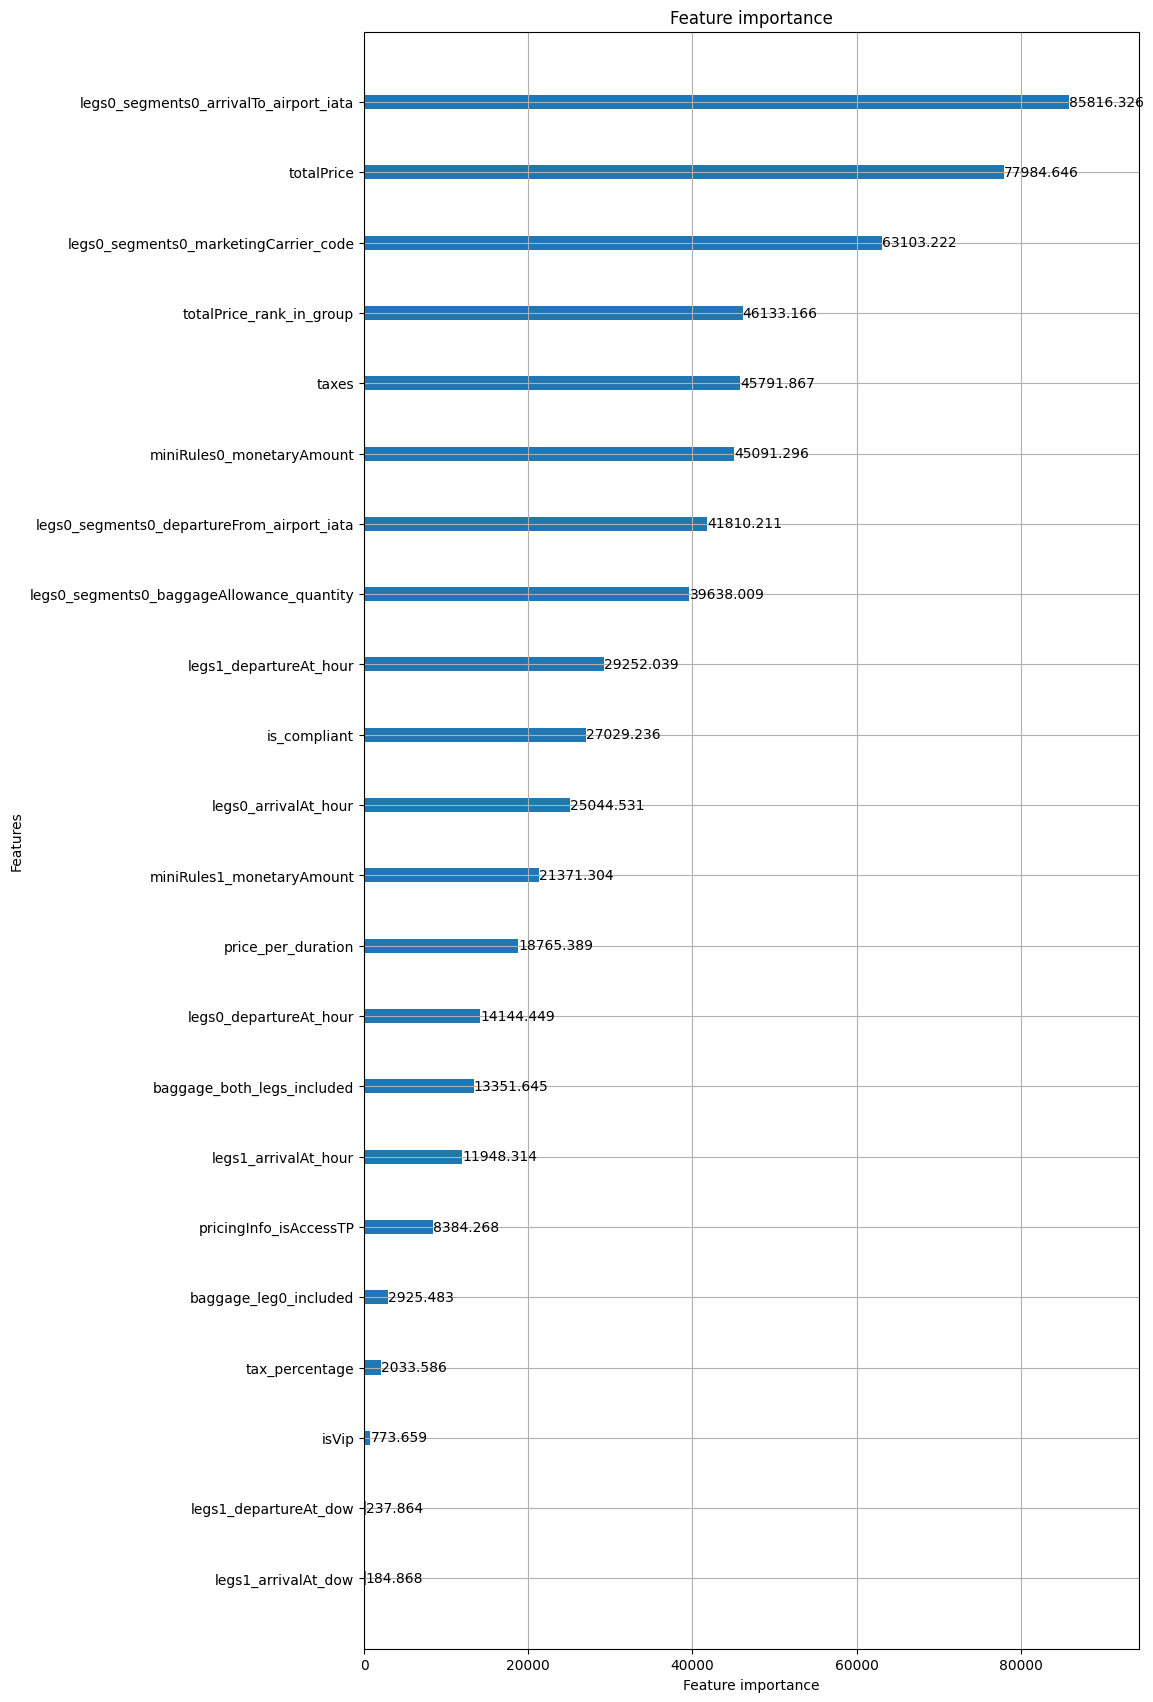

In [6]:
# Block 6: Model Training

params = {
    'objective': 'lambdarank',
    'metric': 'ndcg', 
    'eval_at': [2],   
    'boosting_type': 'gbdt',
    'n_estimators': 500,
    'learning_rate': 0.15,
    'num_leaves': 7,
    'max_depth': 4,
    'min_child_samples': 200,
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'max_bin': 63,
    'random_state': 42,
    'n_jobs': -1,
    'importance_type': 'gain',
    'verbose': -1,
    'seed': 42    
}

NFOLDS = 5 
group_kfold = GroupKFold(n_splits=NFOLDS)

oof_preds_scores = np.zeros(len(X))
test_preds_scores = np.zeros(len(X_test))
models = []
fold_hit_rates = []

# categorical_features_for_encoding 
cat_features_for_lgbm_indices_final = [X.columns.get_loc(col_name) for col_name in categorical_features_for_encoding if col_name in X.columns]
if cat_features_for_lgbm_indices_final:
    print(f"Using categorical feature indices for LightGBM: {cat_features_for_lgbm_indices_final}")
    print(f"Corresponding feature names: {[X.columns[i] for i in cat_features_for_lgbm_indices_final]}")
else:
    print("No categorical features identified for LightGBM native handling.")


for fold_, (train_idx, val_idx) in enumerate(group_kfold.split(X, y, groups=train_ranker_ids)): # train_ranker_ids từ Cell 4
    print(f"====== Fold {fold_+1}/{NFOLDS} ======")
    
    if fold_ > 0: gc.collect() 

    X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
    X_val_fold, y_val_fold = X.iloc[val_idx], y.iloc[val_idx]
    print(f"  Train fold shape: {X_train_fold.shape}, Val fold shape: {X_val_fold.shape}")

    current_train_fold_ranker_ids = train_ranker_ids.iloc[train_idx]
    current_val_fold_ranker_ids = train_ranker_ids.iloc[val_idx]

    train_fold_groups = pd.DataFrame({'ranker_id': current_train_fold_ranker_ids}).groupby('ranker_id', sort=False).size().to_list()
    val_fold_groups = pd.DataFrame({'ranker_id': current_val_fold_ranker_ids}).groupby('ranker_id', sort=False).size().to_list()

    ranker = lgb.LGBMRanker(**params)
    try:
        print(f"  Starting LightGBM fit for fold {fold_+1}...")
        ranker.fit(
            X_train_fold, y_train_fold,
            group=train_fold_groups,
            eval_set=[(X_val_fold, y_val_fold)],
            eval_group=[val_fold_groups],
            eval_metric='ndcg',
            callbacks=[lgb.early_stopping(10, verbose=False)],
            categorical_feature=cat_features_for_lgbm_indices_final if cat_features_for_lgbm_indices_final else 'auto'
        )
        print(f"  LightGBM fit completed for fold {fold_+1}.")
    except Exception as e:
        print(f"Error during LightGBM fit in fold {fold_+1}: {e}")
        print(f"  X_train_fold mem: {X_train_fold.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        print(f"  X_val_fold mem: {X_val_fold.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        break 

    models.append(ranker)
    val_fold_scores = ranker.predict(X_val_fold)
    oof_preds_scores[val_idx] = val_fold_scores
    
    print(f"  Predicting on X_test (shape: {X_test.shape})...")
    current_test_preds = ranker.predict(X_test)
    test_preds_scores += current_test_preds / NFOLDS
    del current_test_preds; gc.collect()

    val_df_for_metric = pd.DataFrame({
        'ranker_id': current_val_fold_ranker_ids,
        'selected': y_val_fold,
        'score': val_fold_scores
    })
    val_df_for_metric['predicted_rank'] = val_df_for_metric.groupby('ranker_id')['score'].rank(method='first', ascending=False).astype(int)
    fold_hr3 = calculate_hit_rate_at_3(val_df_for_metric) # calculate_hit_rate_at_3 
    fold_hit_rates.append(fold_hr3)
    print(f"Fold {fold_+1} HitRate@3: {fold_hr3:.4f}")
    
    del X_train_fold, y_train_fold, X_val_fold, y_val_fold
    del current_train_fold_ranker_ids, current_val_fold_ranker_ids
    del train_fold_groups, val_fold_groups, ranker, val_fold_scores, val_df_for_metric
    gc.collect()

if models and len(models) == NFOLDS:
    oof_df_for_metric = pd.DataFrame({
        'ranker_id': train_ranker_ids,
        'selected': y,
        'score': oof_preds_scores
    })
    oof_df_for_metric['predicted_rank'] = oof_df_for_metric.groupby('ranker_id')['score'].rank(method='first', ascending=False).astype(int)
    overall_oof_hr3 = calculate_hit_rate_at_3(oof_df_for_metric)
    print(f"\nOverall OOF HitRate@3: {overall_oof_hr3:.4f}")
    if fold_hit_rates: print(f"Mean Fold HitRate@3: {np.mean(fold_hit_rates):.4f}")

    print("\nFeature Importances (from last model):")
    try:
        lgb.plot_importance(models[-1], figsize=(10, max(15, len(X.columns)//2)), max_num_features=len(X.columns), importance_type='gain')
    except Exception as e:
        print(f"Could not plot feature importance: {e}")
elif models:
     print(f"\nTraining completed for {len(models)} out of {NFOLDS} folds. Cannot reliably calculate overall OOF score.")
else:
    print("No models were trained successfully.")

In [7]:
# Laat Block
#Use the test_ids_df we saved earlier which has original Id and ranker_id
submission_df = test_ids_df.copy()
submission_df['score'] = test_preds_scores 

submission_df['selected'] = submission_df.groupby('ranker_id')['score'].rank(method='first', ascending=False).astype(int)

# Select only required columns and ensure correct order
submission_df = submission_df[['Id', 'ranker_id', 'selected']]

# Check submission format against sample
print("\nSample Submission:")
print(sample_submission_df.head())
print("\nOur Submission:")
print(submission_df.head())

# Save submission
submission_df.to_parquet('submission.parquet', index=False)
submission_df.to_csv('submission.csv', index=False)
print("\nSubmission file 'submission.parquet' created successfully.")
print(f"Submission shape: {submission_df.shape}")

# Basic validation of submission
# 1. All Ids from test set are present
assert len(submission_df) == len(test_ids_df), "Number of rows doesn't match test set"
assert submission_df['Id'].nunique() == len(test_ids_df['Id'].unique()), "Mismatch in unique Ids"

# 2. Ranks are integers and start from 1
assert submission_df['selected'].min() >= 1, "Ranks should be >= 1"
assert submission_df['selected'].dtype == 'int', "Ranks should be integers"

# 3. Ranks are a valid permutation within each group
def check_rank_permutation(group):
    N = len(group)
    sorted_ranks = sorted(list(group['selected']))
    expected_ranks = list(range(1, N + 1))
    if sorted_ranks != expected_ranks:
        print(f"Invalid rank permutation for ranker_id: {group['ranker_id'].iloc[0]}")
        print(f"Expected: {expected_ranks}, Got: {sorted_ranks}")
        return False
    return True

print("Basic submission validation checks passed (row count, Id uniqueness, rank min value, rank dtype).")


Sample Submission:
                Id                         ranker_id  selected
18144679  18144679  c9373e5f772e43d593dd6ad2fa90f67a       178
18144680  18144680  c9373e5f772e43d593dd6ad2fa90f67a       363
18144681  18144681  c9373e5f772e43d593dd6ad2fa90f67a       277
18144682  18144682  c9373e5f772e43d593dd6ad2fa90f67a       183
18144683  18144683  c9373e5f772e43d593dd6ad2fa90f67a        55

Our Submission:
                Id                         ranker_id  selected
18144679  18144679  c9373e5f772e43d593dd6ad2fa90f67a         6
18144680  18144680  c9373e5f772e43d593dd6ad2fa90f67a        25
18144681  18144681  c9373e5f772e43d593dd6ad2fa90f67a       194
18144682  18144682  c9373e5f772e43d593dd6ad2fa90f67a       150
18144683  18144683  c9373e5f772e43d593dd6ad2fa90f67a       139

Submission file 'submission.parquet' created successfully.
Submission shape: (6897776, 3)
Basic submission validation checks passed (row count, Id uniqueness, rank min value, rank dtype).
